This notebook uses segmentation model's prediction to extract axial 2D slices from T2W modality from heights that include tumor.

A few papers have used T2W modality to get good AUC scores:
- https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1118/1.4948668
- http://www.ajnr.org/content/early/2021/03/04/ajnr.A7029

In [1]:
import pandas as pd
import numpy as np
import torch
import torchio as tio
from torch.utils.data import Dataset
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.auto import tqdm

In [2]:
df_features = pd.read_csv('../input/train_feature_data_v2.csv')
df_features.head()

Unnamed: 0  BraTS21ID  MGMT_value  fold    mesh_volume  surface_area  \
0           0          0           1     2  159374.833333  20741.269121   
1           1          2           1     2  196020.500000  26098.518115   
2           2          3           0     1  227281.125000  24005.453200   
3           3          5           1     2  278976.750000  31507.001329   
4           4          6           1     0  307876.916667  30149.226650   

   surface_volume_ratio  sphericity  spherical_disproportion  \
0              0.130141    0.685376                 1.459054   
1              0.133142    0.625272                 1.599303   
2              0.105620    0.750268                 1.332857   
3              0.112938    0.655323                 1.525964   
4              0.097926    0.731351                 1.367332   

   maximum_3d_diameter  ...   mean_ax_1  median_ax_1  percentile90_ax_1  \
0           237.766692  ...  165.275800        165.0              194.0   
1           135.417872  ...  177.636621        178.0              205.0   
2           115.047816  ...  158.150338        158.0              190.0   
3           171.642069  ...  170.655096        169.0              206.0   
4           140.484875  ...  141.050640        139.0              181.0   

   maximum_ax_1  minimum_ax_2  percentile10_ax_2  mean_ax_2  median_ax_2  \
0           211            25               31.0  41.037986         41.0   
1           220            32               41.0  55.660076         55.0   
2           213            49               62.0  74.993091         75.0   
3           229            33               55.0  67.263955         67.0   
4           212            34               42.0  55.577350         55.0   

   percentile90_ax_2  maximum_ax_2  
0               51.0            59  
1               70.0            79  
2               88.0            95  
3               80.0            91  
4               71.0            83  

[5 rows x 114 columns]

In [3]:
train_dir = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'

In [4]:
def get_crop_bb(image):
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    return bounding_box
    
def crop_with_bb(image, bounding_box):
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

def crop_tio_image(tio_image):
    sitk_image = tio_image.as_sitk()
    sitk_image = crop_with_bb(sitk_image, get_crop_bb(sitk_image))
    arr = sitk.GetArrayFromImage(sitk_image)
    arr = np.swapaxes(arr, 0,2)
    return tio.ScalarImage(tensor=np.expand_dims(arr, axis=0))

In [5]:
tio_augmentations = tio.Compose([
        tio.RandomAffine(p=0.5),
        tio.RandomBiasField(p=0.3),
        tio.RandomGhosting(p=0.05),
        tio.RandomElasticDeformation(p=0.2),
        tio.RandomSpike(p=0.05),
        tio.RandomNoise(p=0.1),
        tio.RandomAnisotropy(p=0.05),
        tio.RandomBlur(p=0.1),
        tio.RandomGamma(p=0.15),
    ])

In [6]:
def extract_tumor_height(arr, features):
    min_tumor_height = features['percentile10_ax_2'] / 100
    max_tumor_height = features['percentile90_ax_2'] / 100
    if min_tumor_height == max_tumor_height:
        tumor_height = 0.5
    else:
        tumor_height = np.random.random() * (max_tumor_height - min_tumor_height) + min_tumor_height
    tumor_height = int(tumor_height*arr.shape[3])
    
    return arr[:,:,:,tumor_height]

In [7]:
# preprocess samples
out_dir = '../input/aligned_and_cropped_t2w/'
if 0:
    if not os.path.exists(out_dir): os.mkdir(out_dir)
    for idx in tqdm(range(len(df_features))):
        row = df_features.iloc[idx]
        bratsid = f'{int(row.BraTS21ID):05d}'
        save_fn = os.path.join(out_dir,f'{bratsid}.npy')
        if os.path.exists(save_fn):
            continue
        
        # load image
        try:
            tio_image = tio.ScalarImage(os.path.join(train_dir, bratsid, 'T2w'))
            tio_image = preprocess.apply_transform(tio_image)

            crop_image = crop_tio_image(tio_image)

            np.save(save_fn, crop_image.numpy())
        except:
            np.save(save_fn, np.zeros((1, 134, 170, 143)).astype(np.int16))

In [51]:
class MICCAI2DDataset(Dataset):
    """ 
    Dataset that aligns T2W stack and normalizes slice thickness to 1.
    Axial 2D images are MIPed (max. intensity projection) from tumor region height.
    """

    def __init__(self, 
                 df_features,
                 image_dir=None,
                 npy_dir=None,
                 image_size=(256,256),
                 tio_augmentations=None,
                 is_train=True,
                 mip_window=0.1 # maximum intensity pooling for height slicing
                ):
        
        self.image_size = image_size
        self.image_dir = image_dir
        self.npy_dir = npy_dir
        self.df_features = df_features
        self.tio_augmentations = tio_augmentations
        self.is_train = is_train
        self.mip_window = mip_window
        
        # We use ToCanonical to have a consistent orientation, Resample the images to 1 mm isotropic spacing
        preprocessing_transforms = (
            tio.ToCanonical(),
            tio.Resample(1, image_interpolation='bspline'),
        )
        self.preprocess = tio.Compose(preprocessing_transforms)

        if is_train:
            # shuffle
            self.df_features = self.df_features.sample(frac=1)
            
            # method for placing oversampling but not implemented in base dataset
            self._sample_data()

    def _sample_data(self):
        pass
    
    @contextmanager
    def set_split_idx(self, i):
        """ Used by fastai's tta, when activating test time augs """
        if i == 0:
            self.tio_augmentations = tio.Compose([
                tio.RandomAffine(p=0.5),
                tio.RandomFlip(axes=(1,2), p=0.5)
            ])
        for _ in range(8):
            pass
        try: yield self
        finally:
            pass
            

    @staticmethod
    def _normalize(image, min_arr, max_arr):
        """ To [-1,1] range """
        image = (image.astype("float32", copy=False) - min_arr) / (max_arr - min_arr + 1e-6)
        image = image * 2 - 1
        return image
    
    def _resize(self, image):
        image = cv2.resize(image, self.image_size, cv2.INTER_LINEAR)
        return image
    
    def _get_crop_bb(self, image):
        inside_value = 0
        outside_value = 255
        label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
        label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
        bounding_box = label_shape_filter.GetBoundingBox(outside_value)
        return bounding_box
    
    def _crop_with_bb(self, image, bounding_box):
        # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
        return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])
    
    def _crop_tio_image(self, tio_image):
        sitk_image = tio_image.as_sitk()
        sitk_image = self._crop_with_bb(sitk_image, self._get_crop_bb(sitk_image))
        arr = sitk.GetArrayFromImage(sitk_image)
        arr = np.swapaxes(arr, 0,2)
        return tio.ScalarImage(tensor=np.expand_dims(arr, axis=0))
    
    def _extract_tumor_height(self, arr, features):
        """ MIP tumor slice """
        min_tumor_height = features['percentile10_ax_2'] / 100
        max_tumor_height = features['percentile90_ax_2'] / 100
        max_tumor_height -= self.mip_window
        if features['percentile10_ax_2'] == features['percentile90_ax_2']:
            tumor_height = 0.5
        elif min_tumor_height >= max_tumor_height:
            tumor_height = min(min_tumor_height, 1. - self.mip_window)
        else:
            tumor_height = np.random.random() * (max_tumor_height - min_tumor_height) + min_tumor_height
        tumor_height_start = int(tumor_height*arr.shape[3])
        tumor_height_end = int((tumor_height + self.mip_window)*arr.shape[3])
        
        return np.max(arr[:,:,:,tumor_height_start:tumor_height_end], axis=3)

    def __len__(self):
        return len(self.df_features)
    
    def _create_label(self, row):
        return float(row.MGMT_value)
    
    def __getitem__(self, idx):
        row = self.df_features.iloc[idx]
        bratsid = f'{int(row.BraTS21ID):05d}'
        
        # load image from preprocessed numpy or from dicom
        if self.npy_dir is not None:
            crop_image = tio.ScalarImage(tensor=np.load(os.path.join(self.npy_dir, f'{bratsid}.npy')))
        else:
            tio_image = tio.ScalarImage(os.path.join(self.image_dir, bratsid, 'T2w'))
            tio_image = self.preprocess.apply_transform(tio_image)
            crop_image = self._crop_tio_image(tio_image)
        
        # get min and max values before slicing - this way the normalization will maintain global range better
        tio_arr = crop_image.numpy().astype(np.float32)
        max_arr = np.max(tio_arr)
        min_arr = np.min(tio_arr)
        
        if self.tio_augmentations is not None:
            crop_image = self.tio_augmentations(crop_image)
        
        image = self._extract_tumor_height(crop_image.numpy(), row)
        image = image.astype(np.float32)
        
        # reduce one dimension in case it's (1,128,281) instead of (128,281)
        if len(image.shape) == 3:
            image = image[0]
            
        # resize
        image = self._resize(image)
        # normalize each patient
        image = self._normalize(image, min_arr, max_arr)
        
        # to 3chan rgb
        channels = [image, image, image]
        image = np.stack(channels)
        
        label = self._create_label(row)
        return image, label

## Fastai CNN

In [52]:
fold = 0
train_df = df_features[df_features.fold != fold]
val_df = df_features[df_features.fold == fold]
image_size = (256,256)
npy_dir = out_dir

tio_augmentations = tio.Compose([
        tio.RandomAffine(p=0.5),
        tio.RandomBiasField(p=0.3),
        tio.RandomGhosting(p=0.03),
        tio.RandomElasticDeformation(p=0.2),
        tio.RandomSpike(p=0.05),
        tio.RandomNoise(p=0.3),
        tio.RandomAnisotropy(p=0.05),
        tio.RandomBlur(p=0.1),
        tio.RandomGamma(p=0.3),
        tio.RandomFlip(axes=(1,2), p=0.5)
    ])

ds_t = MICCAI2DDataset(
        train_df, 
        npy_dir=npy_dir,
        image_size=image_size,
        tio_augmentations=tio_augmentations,
        is_train=True
)

ds_v = MICCAI2DDataset(
        val_df, 
        npy_dir=npy_dir,
        image_size=image_size,
        tio_augmentations=None,
        is_train=False
)

In [10]:
import fastai
from fastai.vision.all import *
from fastai.data.core import DataLoaders

In [11]:
num_workers = 8
bs = 32

dls = DataLoaders.from_dsets(ds_t, ds_v, bs=bs, device='cuda', num_workers=num_workers)

In [12]:
%%time
batch = dls.one_batch()

CPU times: user 1min 27s, sys: 1.42 s, total: 1min 28s
Wall time: 19.3 s


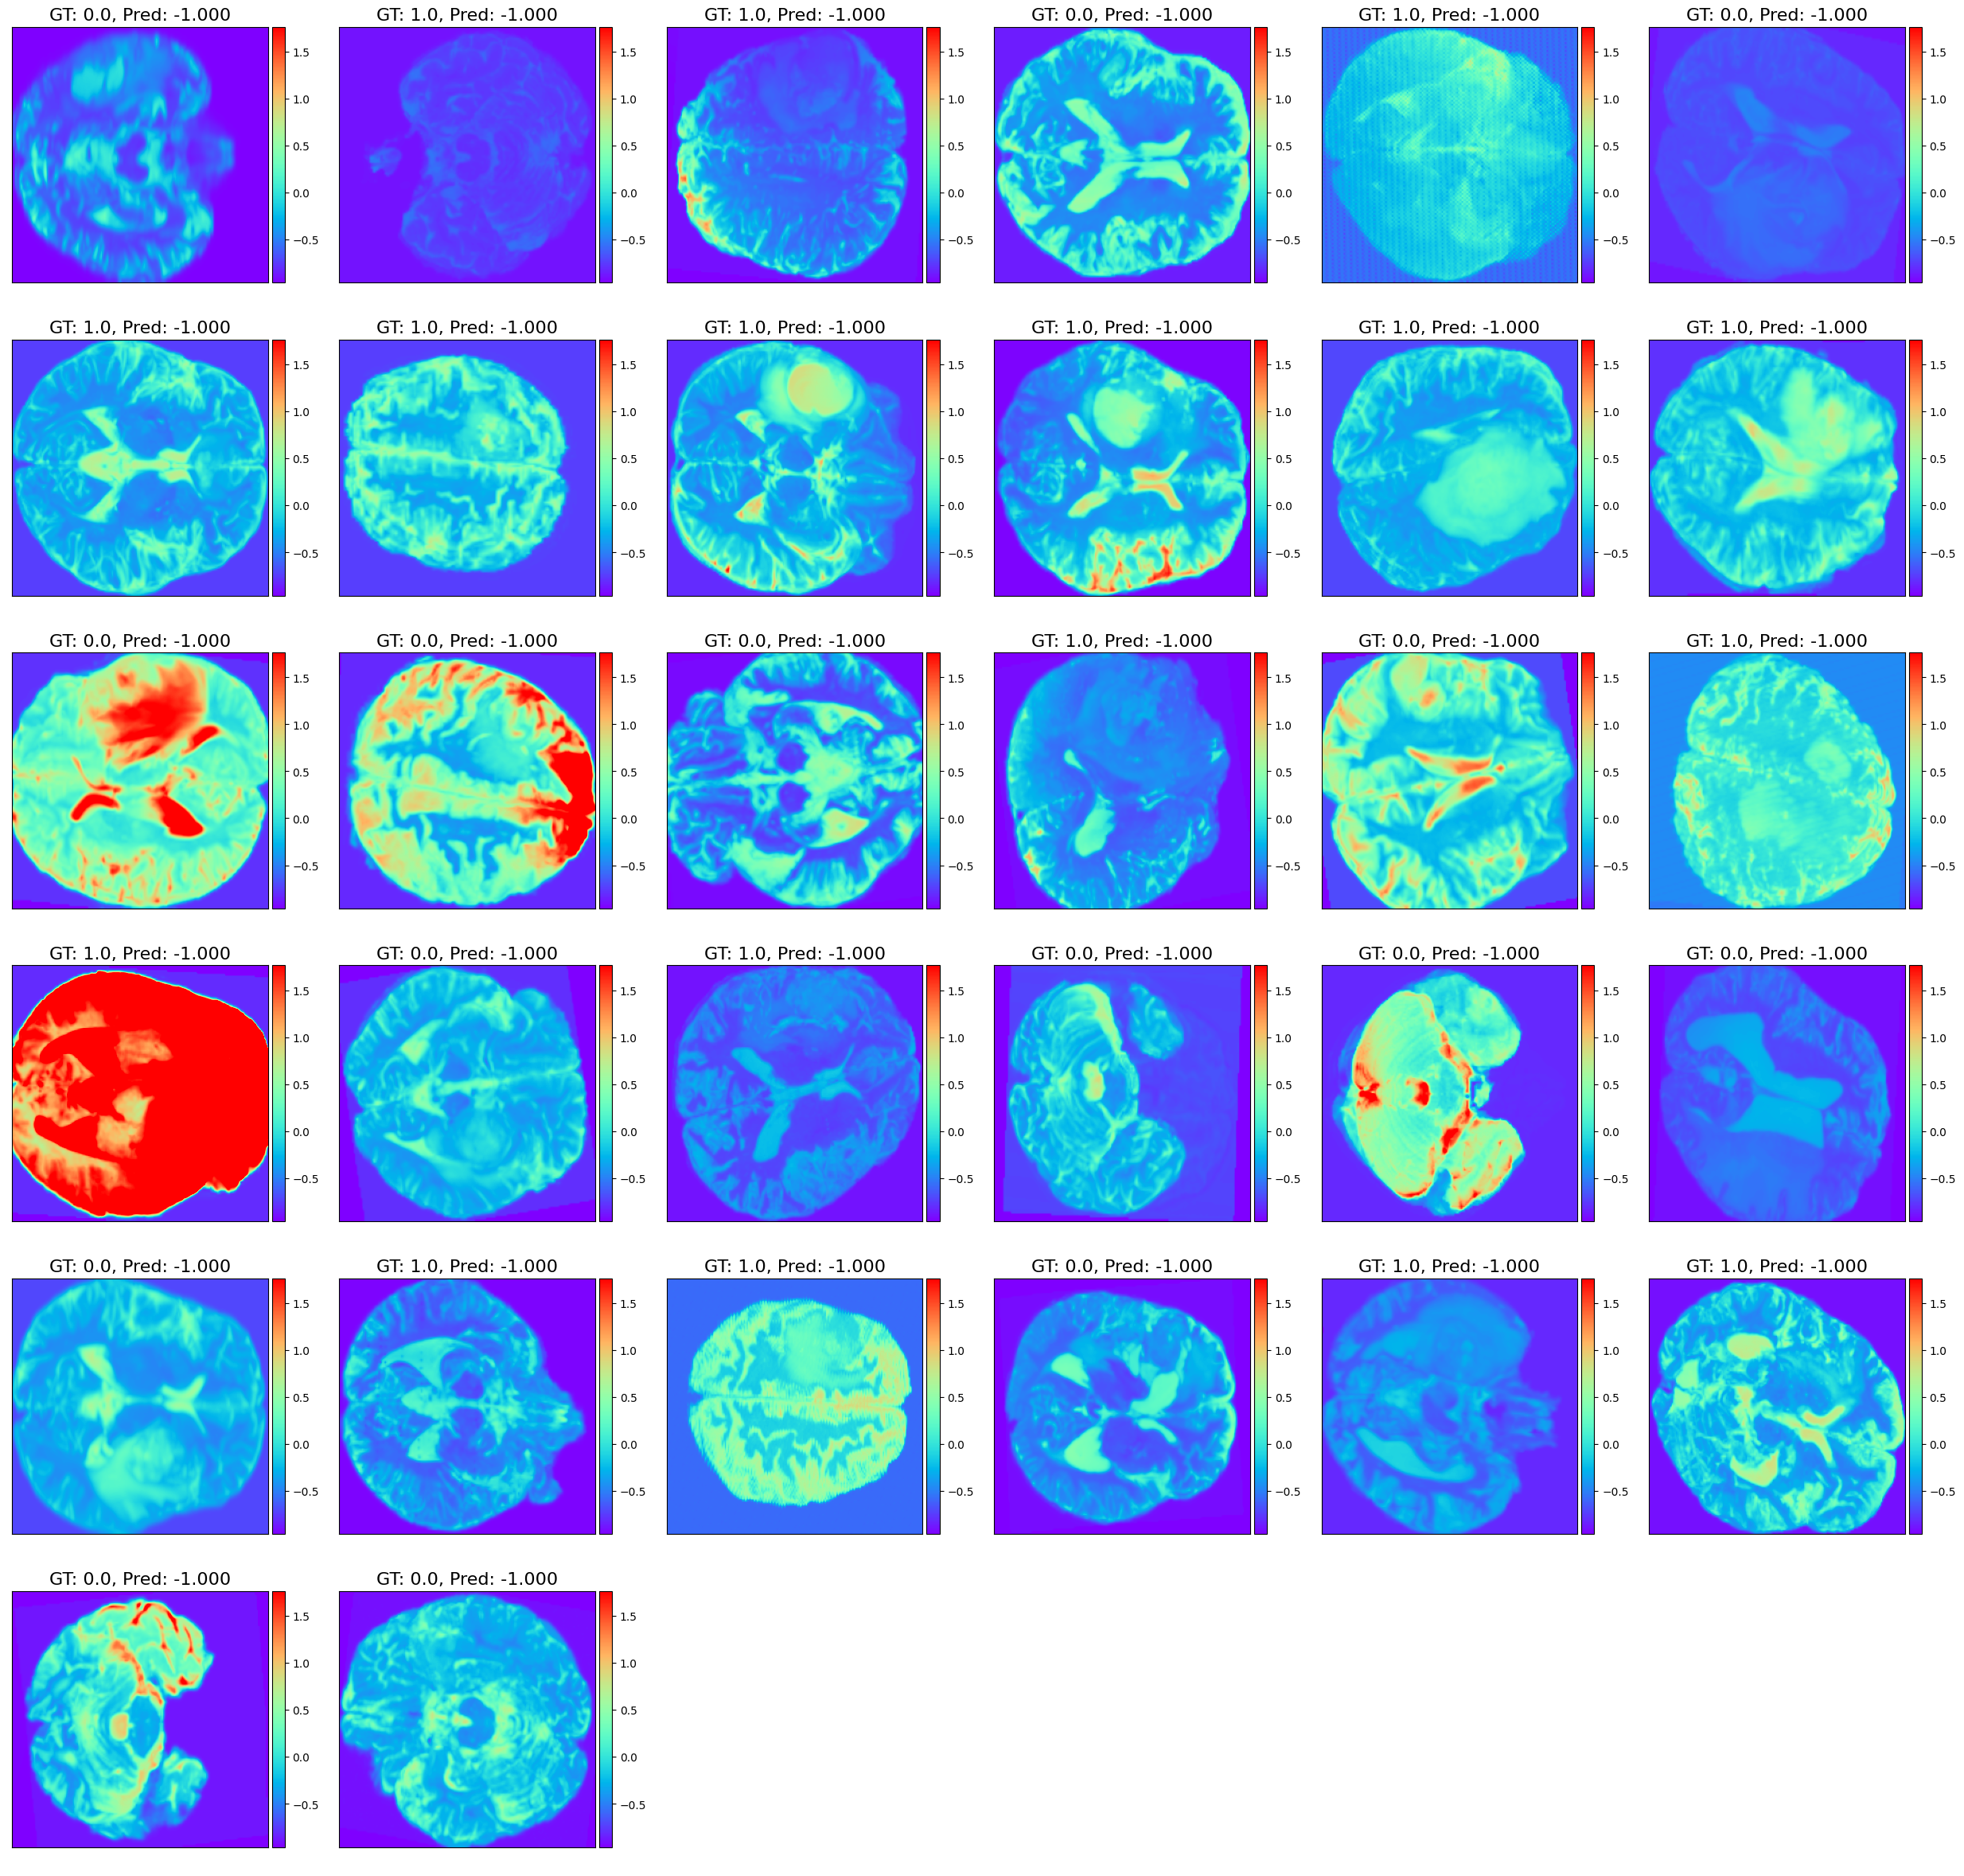

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_2d_batch(batch, preds=None, scale=4, save_fn=None):
    _images, _labels = batch
    images = _images.cpu().numpy()[:,0,:,:] # reduce rgb dimension to grayscale
    labels = _labels.cpu().numpy()
    
    cmap = matplotlib.cm.rainbow
    norm = matplotlib.colors.Normalize(vmin=np.percentile(images, 2), vmax=np.percentile(images, 98))
    
    if preds is not None:
        pred_lbls = list(preds.cpu().numpy())
    else:
        pred_lbls = [-1 for _ in labels]
        
    n_root = int(np.ceil(np.sqrt(len(images))))
    plt.close('all')
    f, axs = plt.subplots(n_root, n_root, figsize=((scale + 1)*n_root, scale*n_root))
    axs = axs.flatten()
    for img, lbl, pred, ax in zip(images, labels, pred_lbls, axs):
        axim = ax.imshow(img, cmap=cmap, norm=norm)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
        
        ax.set_title(f'GT: {lbl}, Pred: {pred:.3f}', fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        
    # hide empties
    for ax_index in range(len(images), len(axs)):
        axs[ax_index].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(left = 0.1, right = 0.9, wspace=0.2, hspace=0.05)
    
    if save_fn is not None:
        plt.savefig(save_fn, transparent=False)
    else:
        plt.show()
        
show_2d_batch(batch)

In [14]:
class RocStarLoss(torch.nn.Module):
    """Smooth approximation for ROC AUC
    """
    def __init__(self, delta = 1.0, sample_size = 100, sample_size_gamma = 100, update_gamma_each=100):
        r"""
        Args:
            delta: Param from article
            sample_size (int): Number of examples to take for ROC AUC approximation
            sample_size_gamma (int): Number of examples to take for Gamma parameter approximation
            update_gamma_each (int): Number of steps after which to recompute gamma value.
        """
        super().__init__()
        self.delta = delta
        self.sample_size = sample_size
        self.sample_size_gamma = sample_size_gamma
        self.update_gamma_each = update_gamma_each
        self.steps = 0
        size = max(sample_size, sample_size_gamma)

        # Randomly init labels
        self.y_pred_history = torch.rand((size, 1)).cuda()
        self.y_true_history = torch.randint(2, (size, 1)).cuda()
    
    def forward(self, y_pred, target):
        """
        Args:
            y_pred: Tensor of model predictions in [0, 1] range. Shape (B x 1)
            y_true: Tensor of true labels in {0, 1}. Shape (B x 1)
        """
        y_pred_1 = (torch.softmax(y_pred, 1)[:,1]).unsqueeze(1)
        y_true = target.unsqueeze(1)
        
        if self.steps % self.update_gamma_each == 0:
            self.update_gamma()
        self.steps += 1
        
        positive = y_pred_1[y_true > 0]
        negative = y_pred_1[y_true < 1]
        
        # Take last `sample_size` elements from history
        y_pred_history = self.y_pred_history[- self.sample_size:]
        y_true_history = self.y_true_history[- self.sample_size:]
        
        positive_history = y_pred_history[y_true_history > 0]
        negative_history = y_pred_history[y_true_history < 1]
        
        if positive.size(0) > 0:
            diff = negative_history.view(1, -1) + self.gamma - positive.view(-1, 1)
            loss_positive = torch.nn.functional.relu(diff ** 2).mean()
        else:
            loss_positive = 0
 
        if negative.size(0) > 0:
            diff = negative.view(1, -1) + self.gamma - positive_history.view(-1, 1)
            loss_negative = torch.nn.functional.relu(diff ** 2).mean()
        else:
            loss_negative = 0
            
        loss = loss_negative + loss_positive
        
        # Update FIFO queue
        batch_size = y_pred_1.size(0)
        self.y_pred_history = torch.cat((self.y_pred_history[batch_size:], y_pred_1.clone().detach()))
        self.y_true_history = torch.cat((self.y_true_history[batch_size:], y_pred_1.clone().detach()))
        return loss

    def update_gamma(self):
        # Take last `sample_size_gamma` elements from history
        y_pred = self.y_pred_history[- self.sample_size_gamma:]
        y_true = self.y_true_history[- self.sample_size_gamma:]
        
        positive = y_pred[y_true > 0]
        negative = y_pred[y_true < 1]
        
        # Create matrix of size sample_size_gamma x sample_size_gamma
        diff = positive.view(-1, 1) - negative.view(1, -1)
        AUC = (diff > 0).type(torch.float).mean()
        num_wrong_ordered = (1 - AUC) * diff.flatten().size(0)
        
        # Adjuct gamma, so that among correct ordered samples `delta * num_wrong_ordered` were considered
        # ordered incorrectly with gamma added
        correct_ordered = diff[diff > 0].flatten().sort().values
        idx = min(int(num_wrong_ordered * self.delta), len(correct_ordered)-1)
        self.gamma = correct_ordered[idx]

In [15]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [16]:
loss = LabelSmoothingCrossEntropyFlat(eps=0.2)

learn = cnn_learner(
        dls, 
        densenet121, #resnet18, #resnet34,
        pretrained=True,
        n_out=2,
        loss_func=loss,
        opt_func=fastai.optimizer.Adam,
        metrics=[
            RocAucBinary(),
            accuracy
        ],
        ps=0.6
        #cbs=WandbCallback(log=None, log_preds=False, log_model=False)
    ).to_fp16()

In [17]:
#learn.lr_find(num_it=20)
#plt.show()

In [18]:
cbs=[ShowGraphCallback()]
learn.fit_one_cycle(1, 1e-4)
learn.unfreeze()
#learn.fine_tune(finetune_cycle_length_ep, finetune_lr, freeze_epochs=freeze_epochs, cbs=cbs)

In [19]:
#learn.lr_find(num_it=40)
#plt.show()

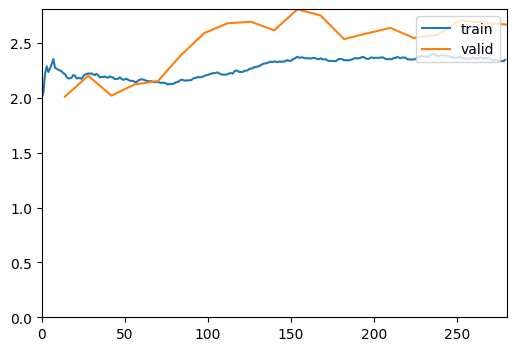

In [20]:
roc_loss = RocStarLoss()
learn.loss_func = roc_loss
learn.fit_flat_cos(20, 1e-4, div_final=2, pct_start=0.99, cbs=cbs)
#learn.fit_sgdr(10,10, 1e-3)

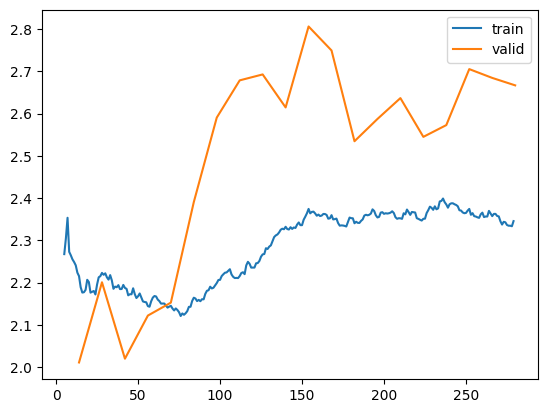

In [21]:
learn.recorder.plot_loss()
plt.show()

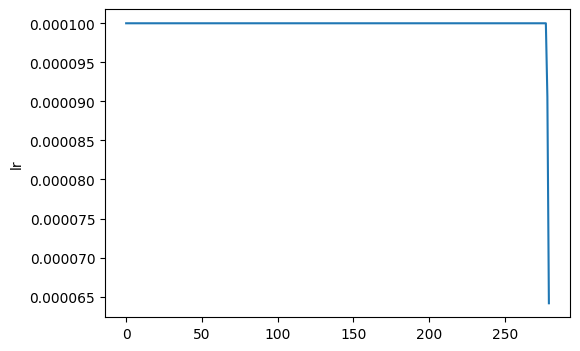

In [22]:
learn.recorder.plot_sched()
plt.show()

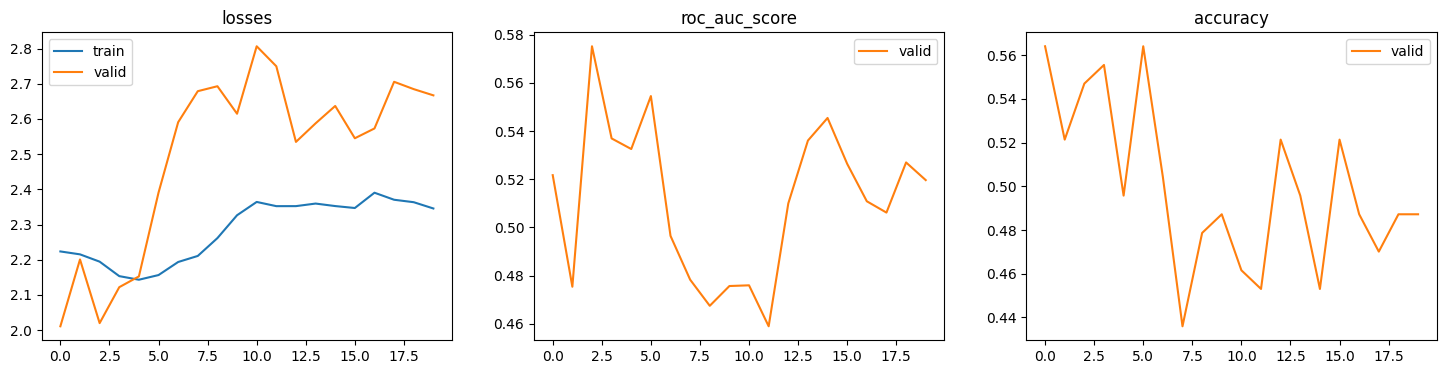

In [23]:
learn.recorder.plot_metrics()

In [24]:
val_batch = dls.valid.one_batch()

In [25]:
val_batch[0].shape

torch.Size([32, 3, 256, 256])

In [26]:
val_pred = learn.model(val_batch[0]).detach()

In [27]:
torch.softmax(val_pred, axis=1)[:,1]

tensor([9.0157e-01, 7.0371e-01, 9.9861e-01, 8.9401e-01, 4.1838e-01, 9.9663e-01,
        9.9559e-01, 8.8546e-01, 7.1418e-02, 9.2787e-01, 5.1842e-01, 9.9309e-01,
        8.8796e-01, 2.1794e-01, 1.4657e-01, 9.7909e-05, 9.5054e-02, 7.7297e-01,
        3.8933e-01, 2.2270e-02, 5.8020e-01, 4.5037e-01, 7.3773e-01, 3.2794e-01,
        5.5258e-01, 9.3446e-01, 9.6989e-02, 6.3327e-03, 1.7771e-01, 4.2987e-01,
        1.8045e-02, 4.9553e-01], device='cuda:0')

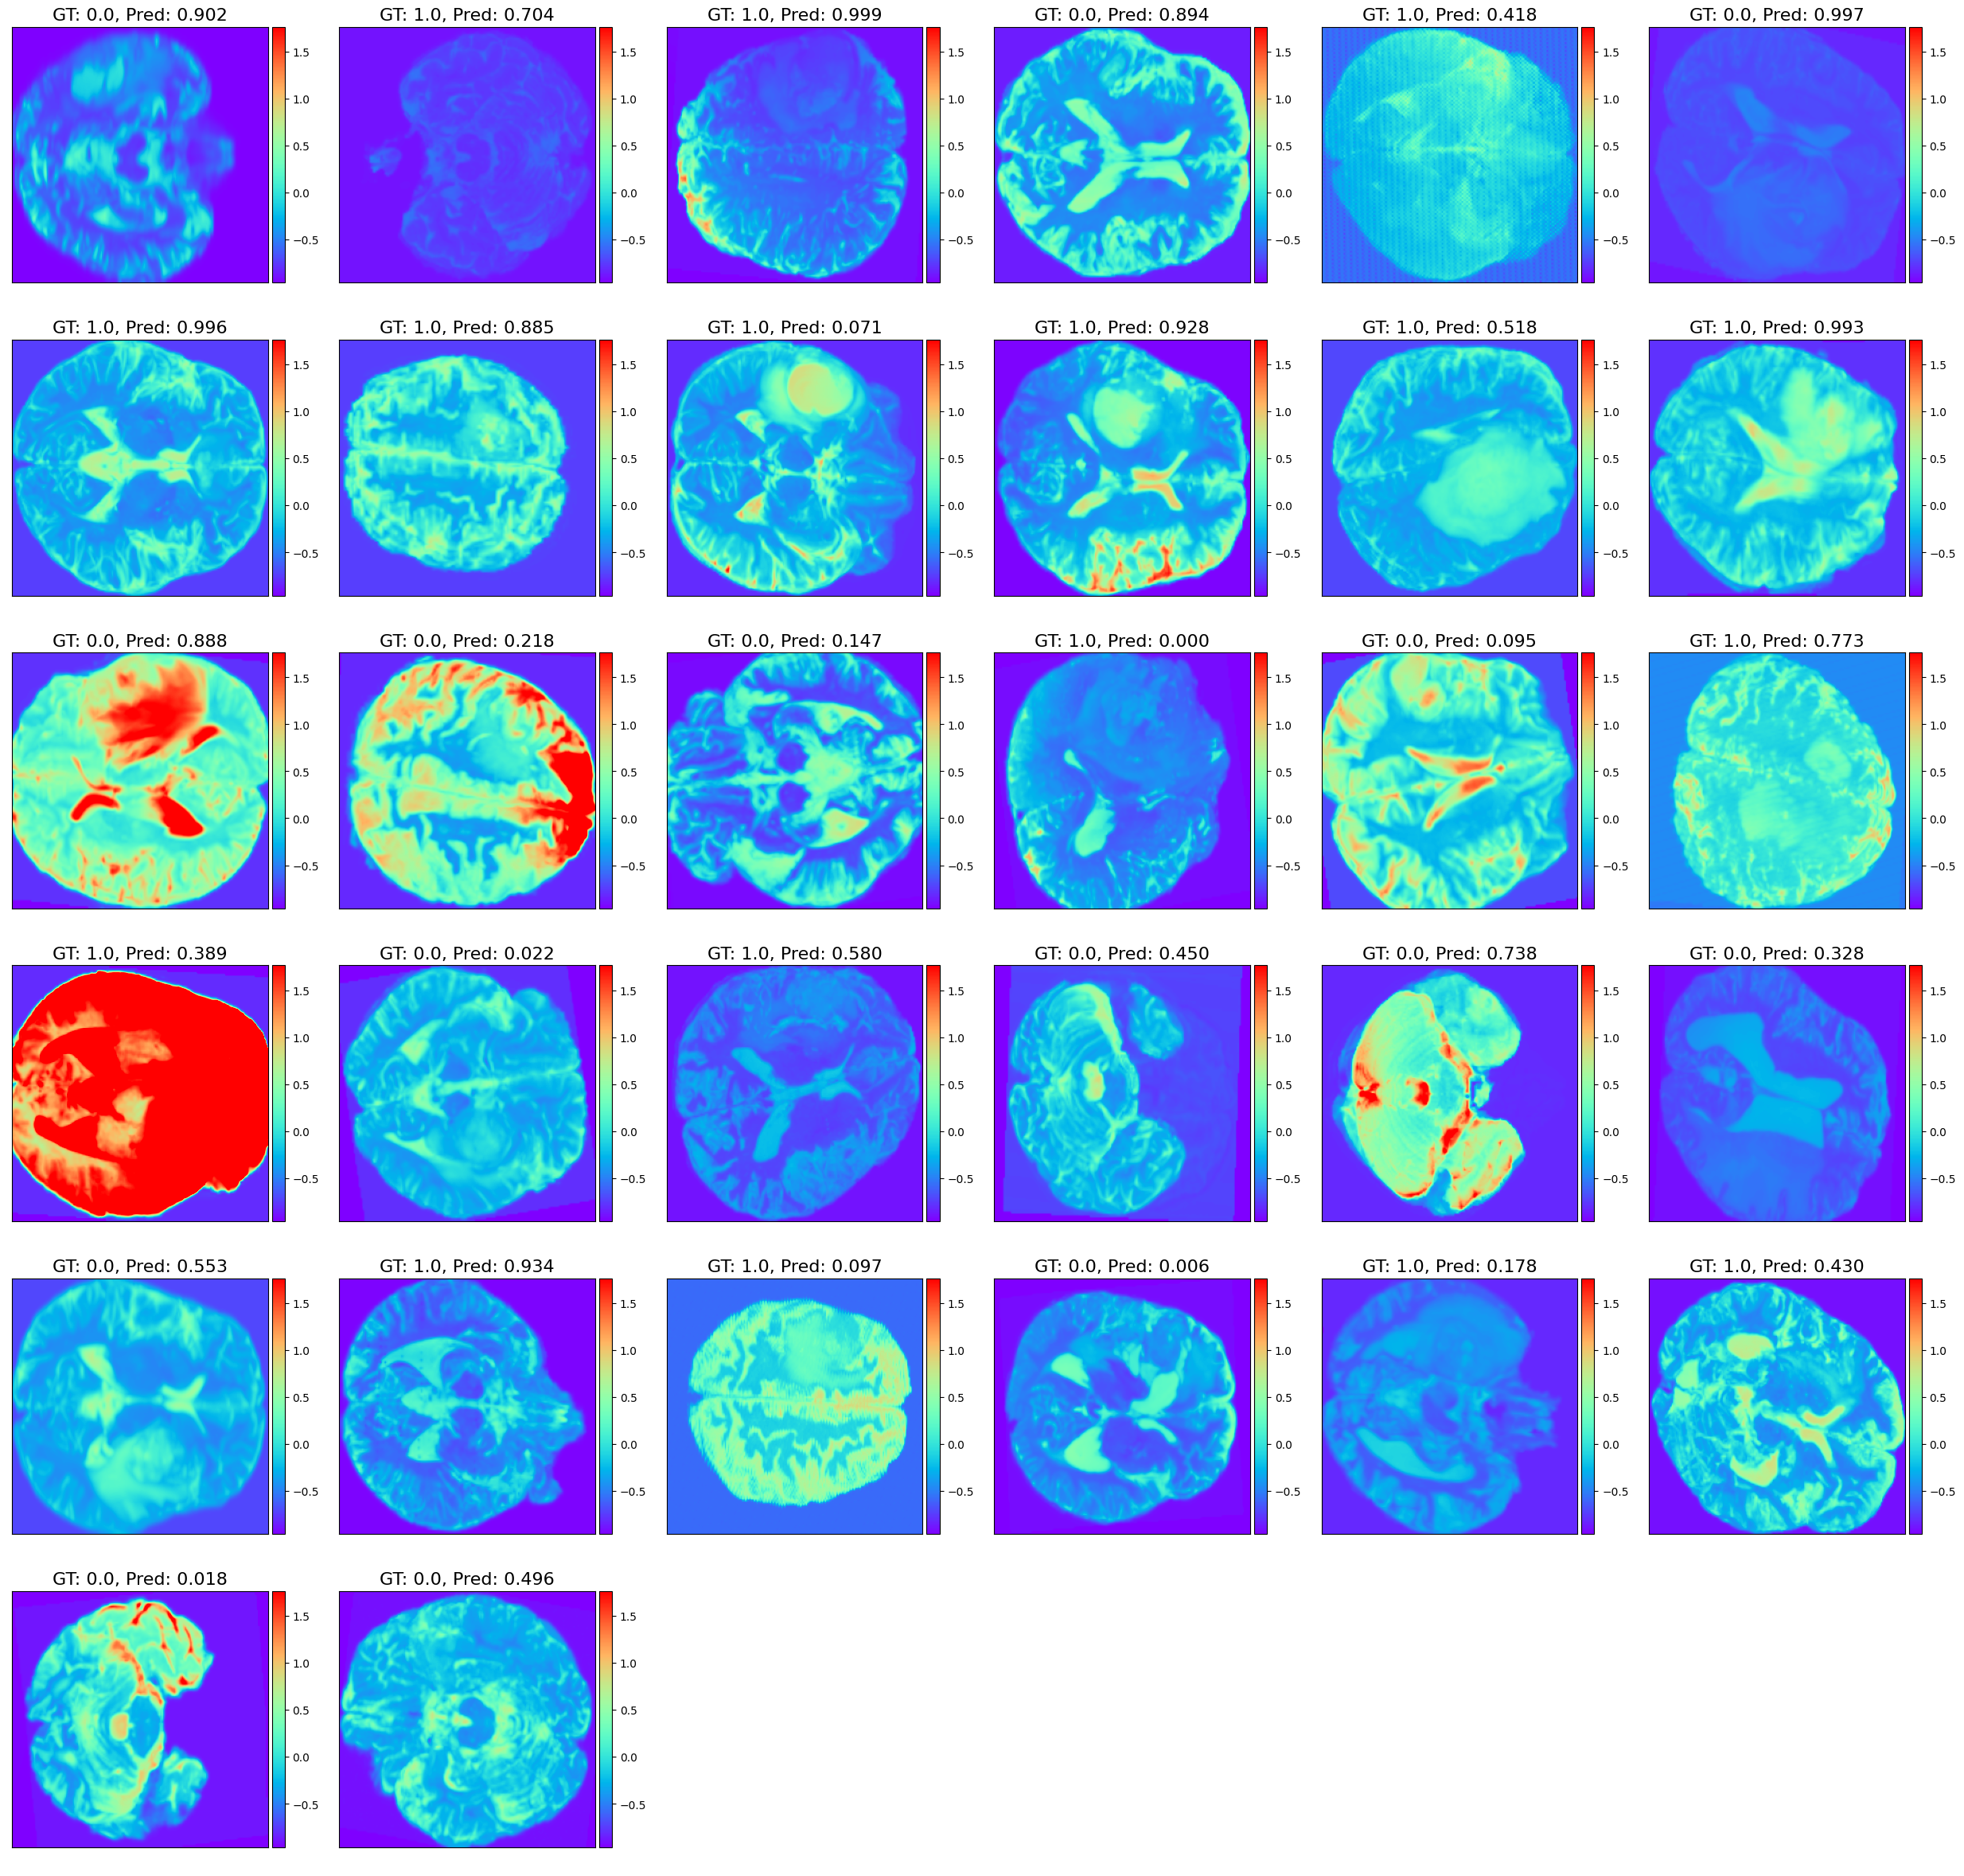

In [28]:
show_2d_batch(batch, preds=torch.softmax(val_pred, axis=1)[:,1])

In [53]:
dl_test = DataLoader(ds_v, 32, num_workers=8, shuffle=False)

In [43]:
test_preds = learn.get_preds(dl=dl_test)

In [66]:
test_p, test_gt = test_preds
test_p = torch.softmax(test_p, 1)
test_p = test_p.numpy()[:,1]
test_gt = test_gt.numpy()

In [54]:
tta_preds = learn.tta(dl=dl_test)

In [67]:
tta_p, tta_gt = tta_preds
tta_p = torch.softmax(tta_p, 1)
tta_p = tta_p.numpy()[:,1]
tta_gt = tta_gt.numpy()

In [69]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(np.array(test_gt), np.array(test_p))
tta_fpr, tta_tpr, _ = roc_curve(np.array(tta_gt), np.array(tta_p))

roc_auc = auc(fpr, tpr)
tta_roc_auc = auc(tta_fpr, tta_tpr)

acc = np.sum((np.array(test_gt) > 0.5) == (np.array(test_p) > 0.5)) / len(test_gt)
tta_acc = np.sum((np.array(test_gt) > 0.5) == (np.array(test_p) > 0.5)) / len(test_gt)

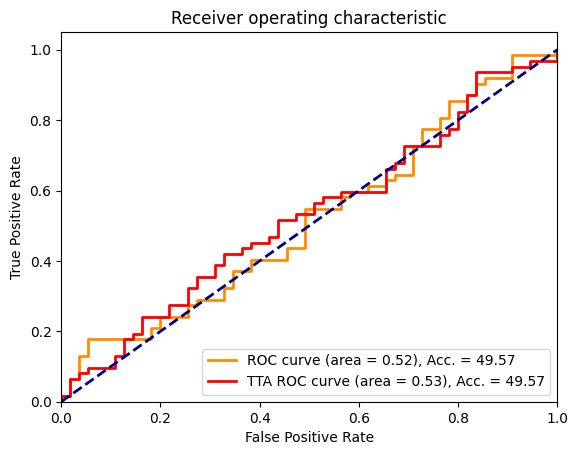

In [70]:
plt.close('all')
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc:.2f}), Acc. = {acc*100:.2f}')
plt.plot(tta_fpr, tta_tpr, color='red',
         lw=lw, label=f'TTA ROC curve (area = {tta_roc_auc:.2f}), Acc. = {tta_acc*100:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(auc_fn, transparent=False)

In [77]:
result_df = val_df.copy()
result_df['pred_mgmt'] = list(test_p)
result_df['pred_mgmt_tta'] = list(tta_p)
result_df.tail()

Unnamed: 0  BraTS21ID  MGMT_value  fold    mesh_volume  surface_area  \
567         567       1000           1     0  200439.125000  26444.075399   
569         569       1002           1     0  161696.791667  22278.174508   
573         573       1007           1     0  153971.541667  20387.637967   
575         575       1009           0     0  125558.833333  19058.707200   
576         576       1010           0     0  199993.000000  27419.288556   

     surface_volume_ratio  sphericity  spherical_disproportion  \
567              0.131931    0.626341                 1.596575   
569              0.137777    0.644276                 1.552129   
573              0.132412    0.681414                 1.467537   
575              0.151791    0.636242                 1.571729   
576              0.137101    0.603167                 1.657915   

     maximum_3d_diameter  ...  percentile90_ax_1  maximum_ax_1  minimum_ax_2  \
567           141.318789  ...              229.0           254            29   
569           122.515305  ...              237.0           254            26   
573           114.021928  ...              216.0           239            21   
575           127.855387  ...              118.0           132            43   
576           155.418789  ...              221.0           246            16   

     percentile10_ax_2  mean_ax_2  median_ax_2  percentile90_ax_2  \
567               36.0  46.826793         47.0               57.0   
569               34.0  45.693694         46.0               57.0   
573               27.0  37.701751         37.0               49.0   
575               50.0  60.662627         60.0               72.0   
576               28.0  38.601741         38.0               49.0   

     maximum_ax_2  pred_mgmt  pred_mgmt_tta  
567            66   0.001435       0.003926  
569            68   0.028194       0.033998  
573            57   0.000048       0.000339  
575            79   0.469095       0.295020  
576            63   0.002790       0.005078  

[5 rows x 116 columns]